### Notebook order

This notebook is the 1st notebook in milestone 1. 

In this notebook, we explore and decide what to do in the data cleaning process.

In [85]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import missingno as msno

import warnings
warnings.filterwarnings("ignore")

In [86]:
train = pd.read_csv("https://raw.githubusercontent.com/MohamedMostafa259/Customer-Churn-Prediction-and-Analysis/main/Data/train.csv")
train_copy = train.copy()

### Data Overview

In [87]:
train_copy.sample(5, random_state=42)

,customer_id,Name,age,gender,security_no,region_category,membership_category,joining_date,joined_through_referral,referral_id,...,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,churn_risk_score
9550,fffe43004900440033003200320035003600,Tobias Liebold,24,F,I4AYTC2,City,Premium Membership,2015-04-22,No,xxxxxxxx,...,101.50,32593.20,15.0,801.18,Yes,No,No,Not Applicable,Products always in Stock,1
7112,fffe43004900440032003200350035003400,Patrick Kizer,53,F,WV0LB6W,Town,Silver Membership,2016-01-19,No,xxxxxxxx,...,324.61,39155.49,21.0,NaN,No,Yes,No,Not Applicable,No reason specified,3
9545,fffe43004900440031003000380038003300,Annamaria Freese,53,F,94O1F22,Town,No Membership,2016-02-07,Yes,CID19334,...,47.71,35434.17,12.0,675.17,Yes,No,No,Not Applicable,Poor Product Quality,5
10261,fffe43004900440034003200300031003800,Gilda Lundy,61,M,74WFG9K,NaN,Gold Membership,2017-10-24,No,xxxxxxxx,...,451.66,30621.93,7.0,755.93,Yes,Yes,Yes,Solved,Poor Product Quality,3
9876,fffe43004900440034003100380030003300,Angla Alameda,46,F,249HVEX,Town,Premium Membership,2016-06-11,No,xxxxxxxx,...,266.68,50462.15,Error,806.67,Yes,Yes,Yes,Solved,Products always in Stock,1


**Comments:**

- What does `'xxxxxxxx'` mean in the `'referral_id'` column?

- The `'avg_frequency_login_days'` numeric column seems to contain values = `'Error'`

In [88]:
train_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36992 entries, 0 to 36991
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   customer_id                   36992 non-null  object 
 1   Name                          36992 non-null  object 
 2   age                           36992 non-null  int64  
 3   gender                        36992 non-null  object 
 4   security_no                   36992 non-null  object 
 5   region_category               31564 non-null  object 
 6   membership_category           36992 non-null  object 
 7   joining_date                  36992 non-null  object 
 8   joined_through_referral       36992 non-null  object 
 9   referral_id                   36992 non-null  object 
 10  preferred_offer_types         36704 non-null  object 
 11  medium_of_operation           36992 non-null  object 
 12  internet_option               36992 non-null  object 
 13  l

In [89]:
train_copy.isna().sum()[train_copy.isna().sum() > 0]

region_category          5428
preferred_offer_types     288
points_in_wallet         3443
dtype: int64

**Comments:**

- These columns contain NaNs:

	-	region_category               
	-	preferred_offer_types         
	-	points_in_wallet              

- The `'avg_frequency_login_days'` numeric column has type of `object`! (from previous comments cell, we found out that it seems to contain values = `'Error'`)

In [90]:
train_copy.describe()

,age,days_since_last_login,avg_time_spent,avg_transaction_value,points_in_wallet,churn_risk_score
count,36992.000000,36992.000000,36992.000000,36992.000000,33549.000000,36992.000000
mean,37.118161,-41.915576,243.472334,29271.194003,686.882199,3.463397
std,15.867412,228.819900,398.289149,19444.806226,194.063624,1.409661
min,10.000000,-999.000000,-2814.109110,800.460000,-760.661236,-1.000000
25%,23.000000,8.000000,60.102500,14177.540000,616.150000,3.000000
50%,37.000000,12.000000,161.765000,27554.485000,697.620000,4.000000
75%,51.000000,16.000000,356.515000,40855.110000,763.950000,5.000000
max,64.000000,26.000000,3235.578521,99914.050000,2069.069761,5.000000


In [91]:
train_copy['churn_risk_score'].value_counts(dropna=False).sort_index()

churn_risk_score
-1     1163
 1     2652
 2     2741
 3    10424
 4    10185
 5     9827
Name: count, dtype: int64

In [92]:
train_copy.describe(include=object)

,customer_id,Name,gender,security_no,region_category,membership_category,joining_date,joined_through_referral,referral_id,preferred_offer_types,medium_of_operation,internet_option,last_visit_time,avg_frequency_login_days,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback
count,36992,36992,36992,36992,31564,36992,36992,36992,36992,36704,36992,36992,36992,36992,36992,36992,36992,36992,36992
unique,36992,36992,3,36992,3,6,1096,3,11359,3,4,3,30101,1654,2,2,2,5,9
top,fffe4300490044003600300030003800,Pattie Morrisey,F,XW0DQ7H,Town,Basic Membership,2015-06-02,No,xxxxxxxx,Gift Vouchers/Coupons,Desktop,Wi-Fi,07:56:41,Error,Yes,Yes,No,Not Applicable,Poor Product Quality
freq,1,1,18490,1,14128,7724,55,15839,17846,12349,13913,12413,6,3522,20342,20440,18602,18602,6350


In [93]:
train_copy['gender'].value_counts(dropna=False)

gender
F          18490
M          18443
Unknown       59
Name: count, dtype: int64

In [94]:
train_copy.loc[train_copy['days_since_last_login'] < 0, 'days_since_last_login'] = np.nan
train_copy.loc[train_copy['avg_time_spent'] < 0, 'avg_time_spent'] = np.nan
train_copy.loc[train_copy['points_in_wallet'] < 0, 'points_in_wallet'] = np.nan
train_copy.loc[train_copy['churn_risk_score'] == -1, 'churn_risk_score'] = np.nan
train_copy.dropna(subset=['churn_risk_score'], inplace=True)

**Comments:**

- Negative values should be set to `np.nan` in these columns:

	-	days_since_last_login
	-	avg_time_spent
	-	points_in_wallet
	-	churn_risk_score (NaNs in the target: these rows needs to be dropped)

-	Target class has imbalanced class distribution

- `'gender'` column contains a category called `'Unknown'`

### Category value counts

In [95]:
for col in train_copy.select_dtypes(include='object').columns:
	print(train_copy[col].value_counts(normalize=True, dropna=False))
	print('-'*50)

customer_id
fffe4300490044003600300030003800        0.000028
fffe43004900440034003700330036003300    0.000028
fffe43004900440032003300340031003500    0.000028
fffe43004900440035003300380031003700    0.000028
fffe43004900440031003800300034003500    0.000028
                                          ...   
fffe43004900440031003400380033003200    0.000028
fffe43004900440031003800360039003700    0.000028
fffe43004900440032003300310035003900    0.000028
fffe43004900440034003700340033003400    0.000028
fffe43004900440033003600340034003200    0.000028
Name: proportion, Length: 35829, dtype: float64
--------------------------------------------------
Name
Pattie Morrisey        0.000028
Christene Creighton    0.000028
Merideth Gebo          0.000028
Neville Goodwill       0.000028
Sol Siemers            0.000028
                         ...   
Lacey Shanahan         0.000028
Jani Burgett           0.000028
Laurette Cantor        0.000028
Silvana Mcgrew         0.000028
Verlene Beaulieu       0.

In [96]:
train_copy.replace('?', np.nan, inplace=True)

In [97]:
train_copy.loc[train_copy['avg_frequency_login_days'] == 'Error', 'avg_frequency_login_days'] = np.nan
train_copy['avg_frequency_login_days'] = train_copy['avg_frequency_login_days'].astype(float)
train_copy.loc[train_copy['avg_frequency_login_days'] < 0, 'avg_frequency_login_days'] = np.nan
train_copy['avg_frequency_login_days'].value_counts(dropna=False, normalize=True)

avg_frequency_login_days
NaN          0.113818
13.000000    0.037986
8.000000     0.037009
19.000000    0.036814
14.000000    0.036702
               ...   
3.342993     0.000028
29.165844    0.000028
1.083765     0.000028
38.526052    0.000028
27.839927    0.000028
Name: proportion, Length: 928, dtype: float64

**Comments:**

-	Around $14\%$ of `'joined_through_referral'` and `'medium_of_operation'` columns = `'?'`
-	cols_to_drop ↓↓

	-	We need to drop unnecessary columns: `train.drop(columns=cols_to_drop, inplace=True)`

-	date_cols ↓↓

In [98]:
cols_to_drop = ['customer_id', 'Name', 'security_no', 'referral_id']

# date_cols = [('date', 'date_format'), ...]
date_cols = [('joining_date', '%Y-%m-%d'), ('last_visit_time', '%H:%M:%S')]

### Check duplicates

In [99]:
train_copy.duplicated(['customer_id']).sum()

0

#### Visualizing distributions

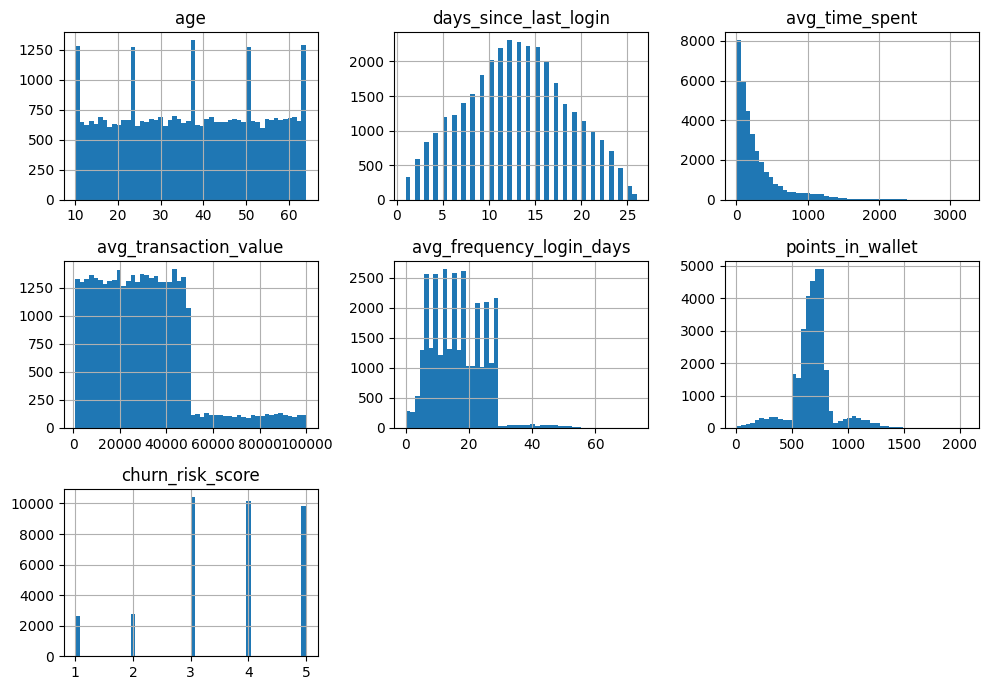

In [100]:
train_copy.hist(bins=50, figsize=(10, 7))
plt.tight_layout()
plt.show()

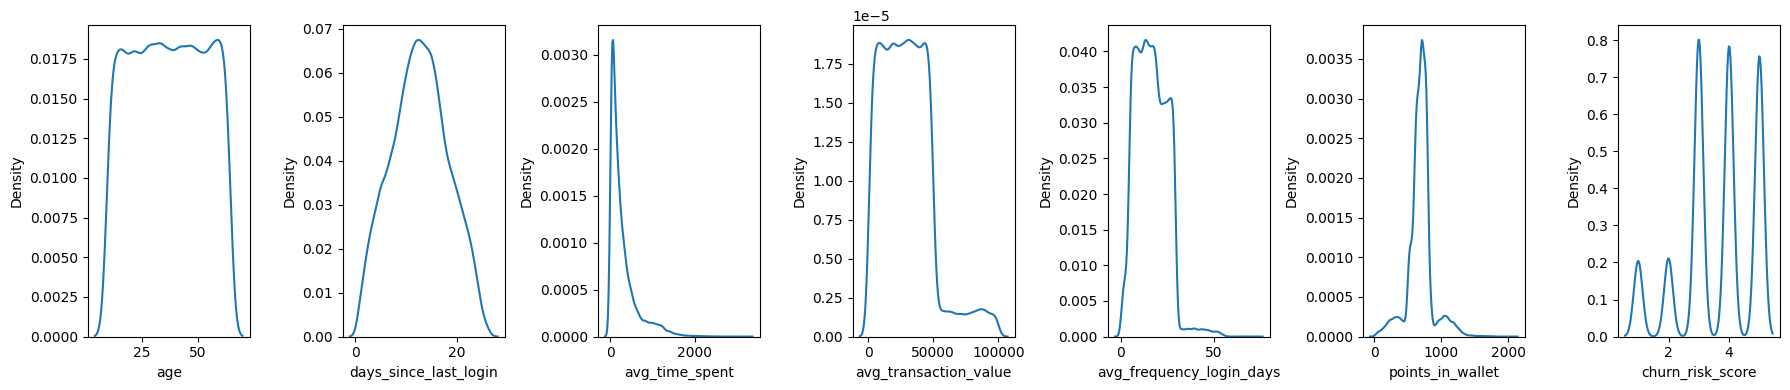

In [101]:
fig, axes = plt.subplots(1, 7, figsize=(18, 4))
idx = 0
for col in train_copy.select_dtypes(include=np.number).columns:
	sns.kdeplot(train_copy[col], ax=axes[idx])
	idx += 1
plt.tight_layout()
plt.show()

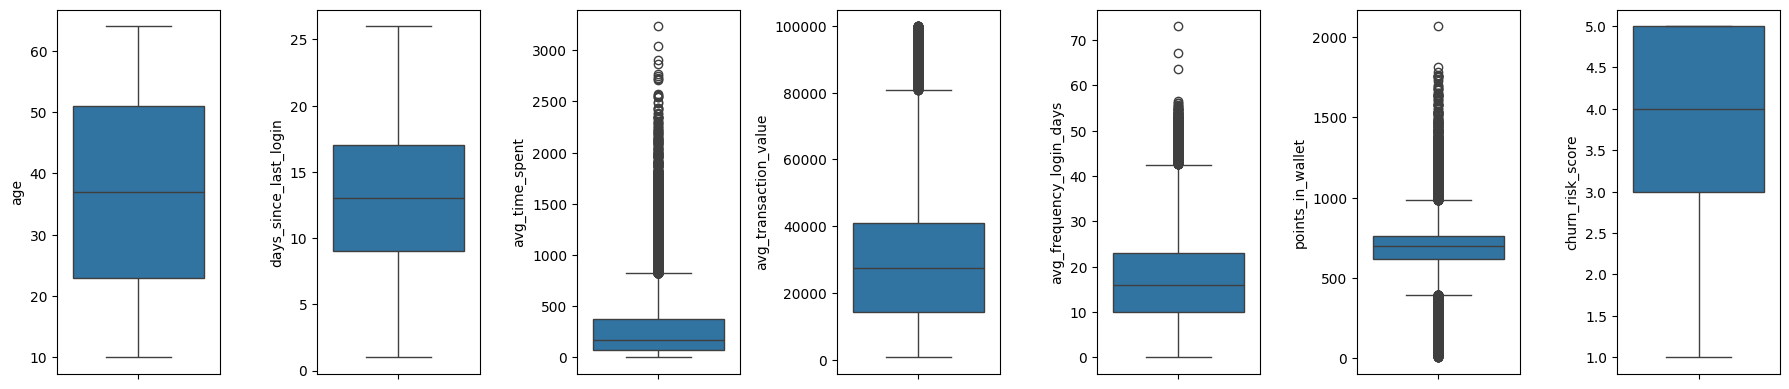

In [102]:
fig, axes = plt.subplots(1, 7, figsize=(18, 4))
idx = 0
for col in train_copy.select_dtypes(include=np.number).columns:
	sns.boxplot(train_copy[col], ax=axes[idx])
	idx += 1
plt.tight_layout()
plt.show()

In [103]:
# cols_with_outliers = ['avg_time_spent', 'avg_transaction_value', 'avg_frequency_login_days', 'points_in_wallet']

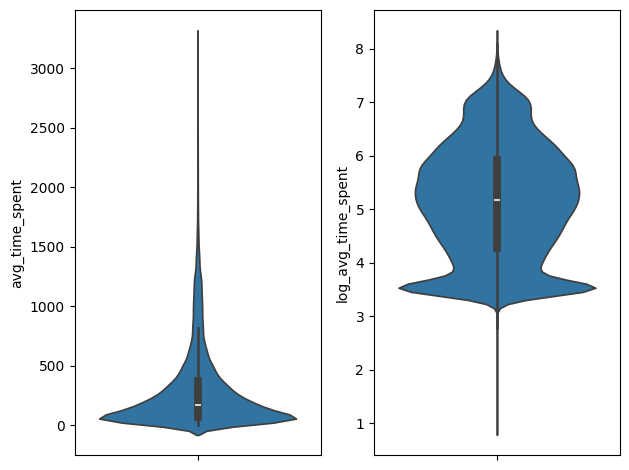

In [104]:
# log1p(x) = log(x + 1): this avoids errors when x = 0
train_copy['log_avg_time_spent'] = np.log1p(train_copy['avg_time_spent'])

fig, axes = plt.subplots(1, 2)
sns.violinplot(train_copy['avg_time_spent'], ax=axes[0])
sns.violinplot(train_copy['log_avg_time_spent'], ax=axes[1])
plt.tight_layout()
plt.show()

**Comments:**

Some columns have non-normal and non-uniform distributions. Also, they have outliers; however, I will not cap these outliers because they may introduce an important pattern in the data, for example, if `avg_transaction_value` has some very high values due to VIP customers, capping them may remove valuable patterns.

So, I will apply log transformation to `avg_time_spent` to make it look more normal as it's right-skewed.

### Missing value analysis

Before imputing NaNs, we need to have a good understanding of how they are distributed in our dataset.

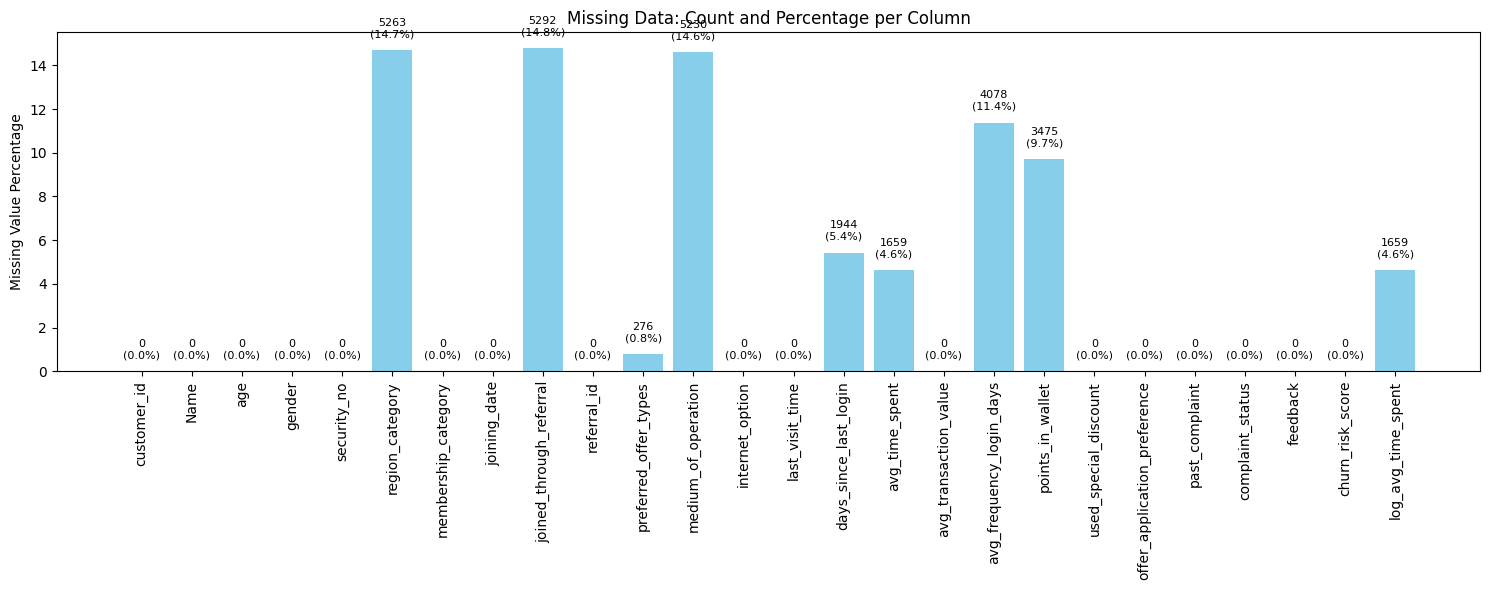

In [105]:
# code source: ChatGPT :)

missing_percent = train_copy.isna().mean() * 100  
missing_count = train_copy.isna().sum()           

plt.figure(figsize=(15, 6))
bars = plt.bar(missing_percent.index, missing_percent, color='skyblue')

# Annotate bars with both count and percentage
for bar, count, percent in zip(bars, missing_count, missing_percent):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             f'{int(count)}\n({percent:.1f}%)',
             ha='center', va='bottom', fontsize=8)

plt.xticks(rotation=90)
plt.ylabel('Missing Value Percentage')
plt.title('Missing Data: Count and Percentage per Column')
plt.tight_layout()
plt.show()


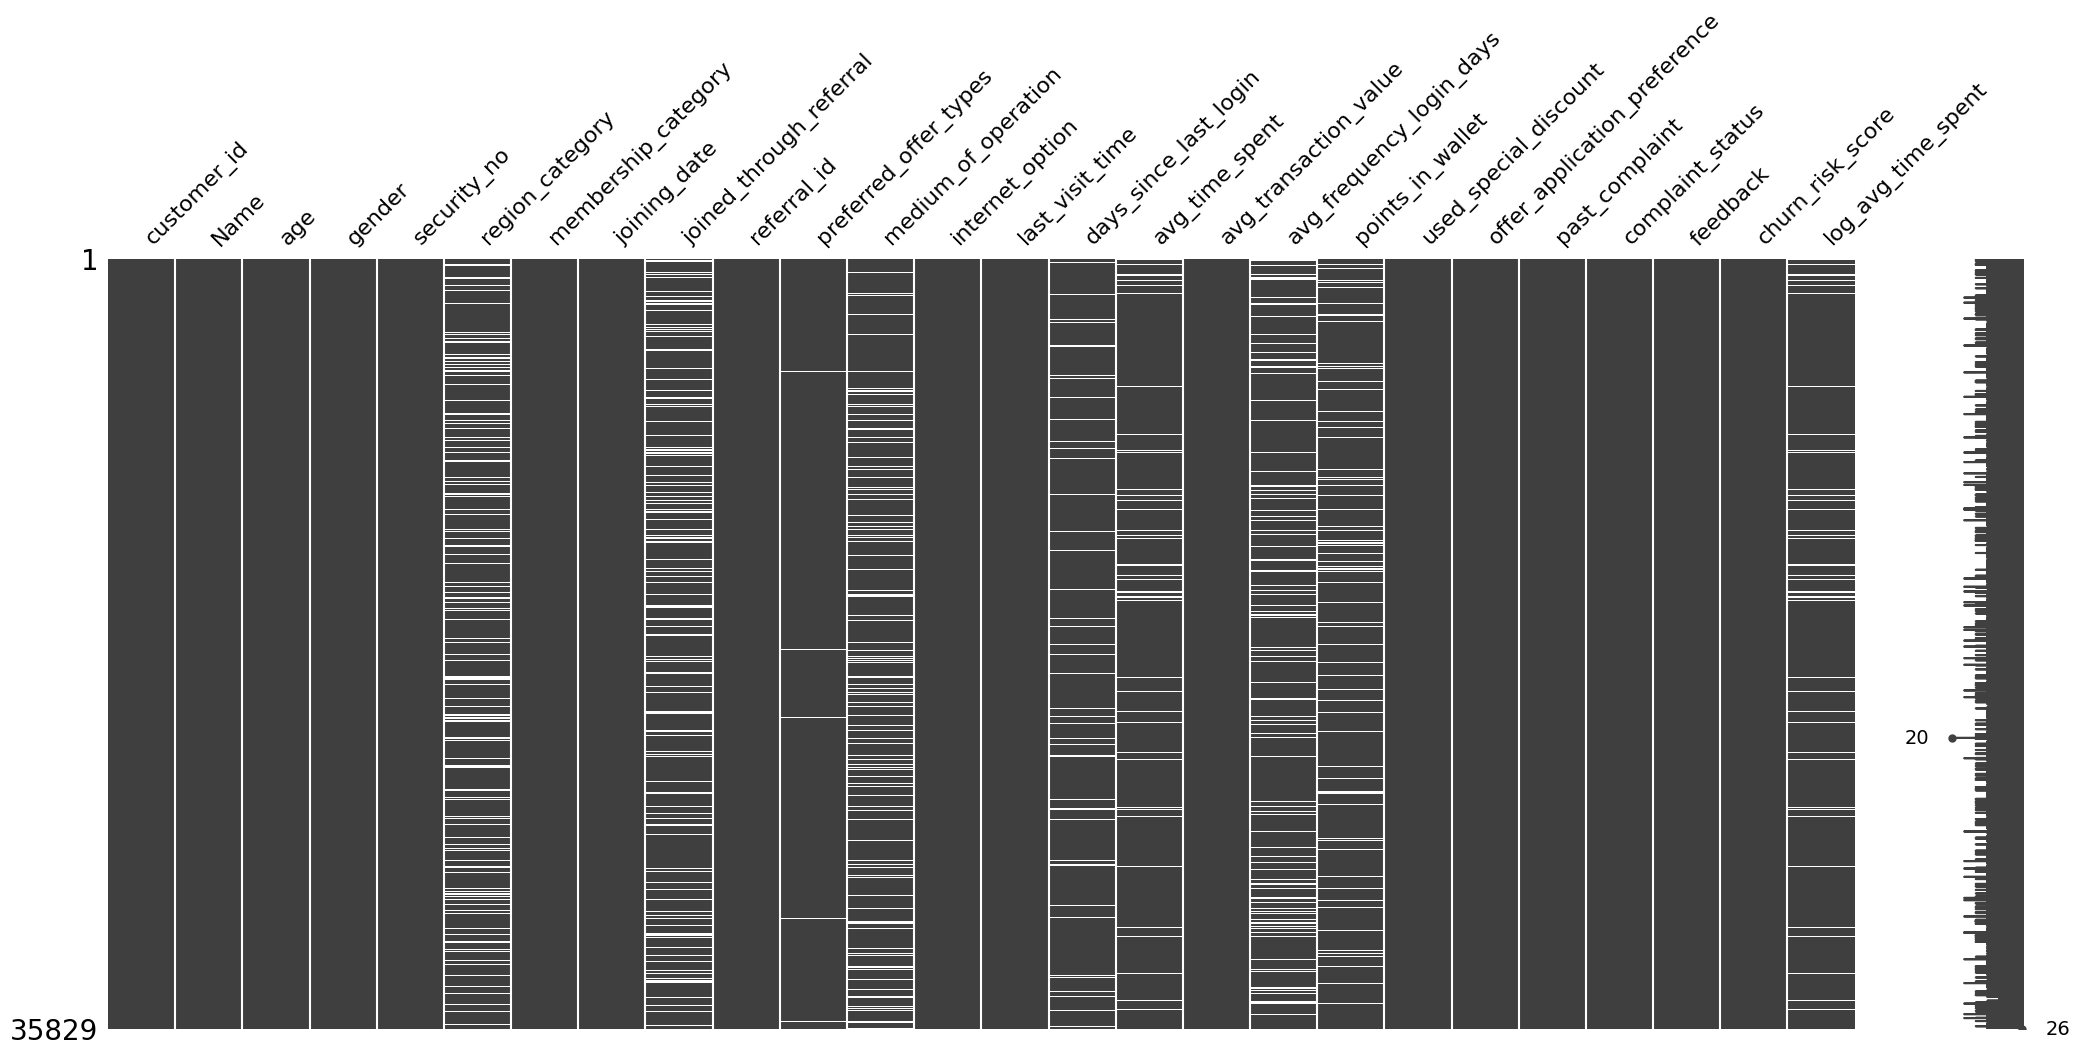

In [106]:
train_copy['last_visit_time'] = pd.to_datetime(train_copy['last_visit_time'])
train_copy.sort_values('last_visit_time', inplace=True)
msno.matrix(train_copy)
plt.show()

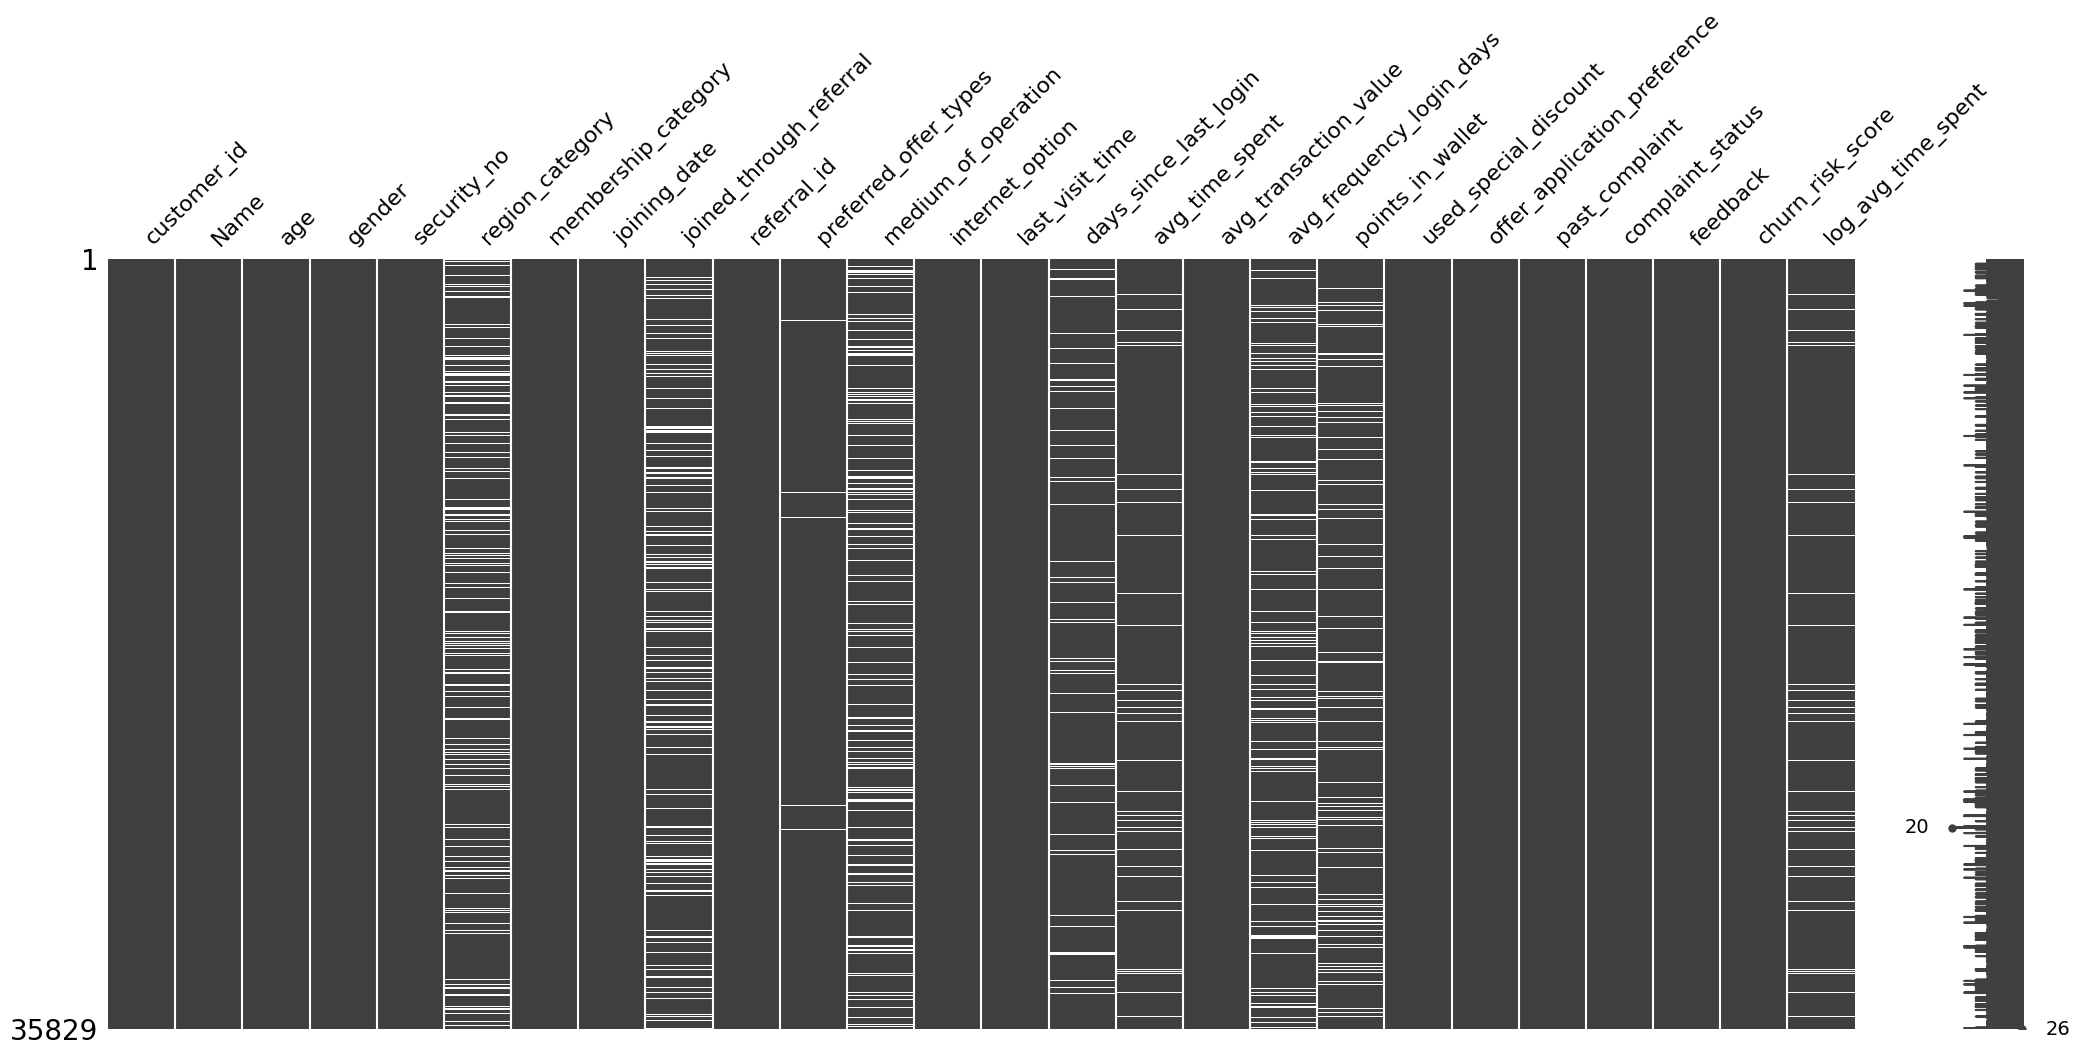

In [107]:
train_copy['joining_date'] = pd.to_datetime(train_copy['joining_date'])
train_copy.sort_values('joining_date', inplace=True)
msno.matrix(train_copy)
plt.show()

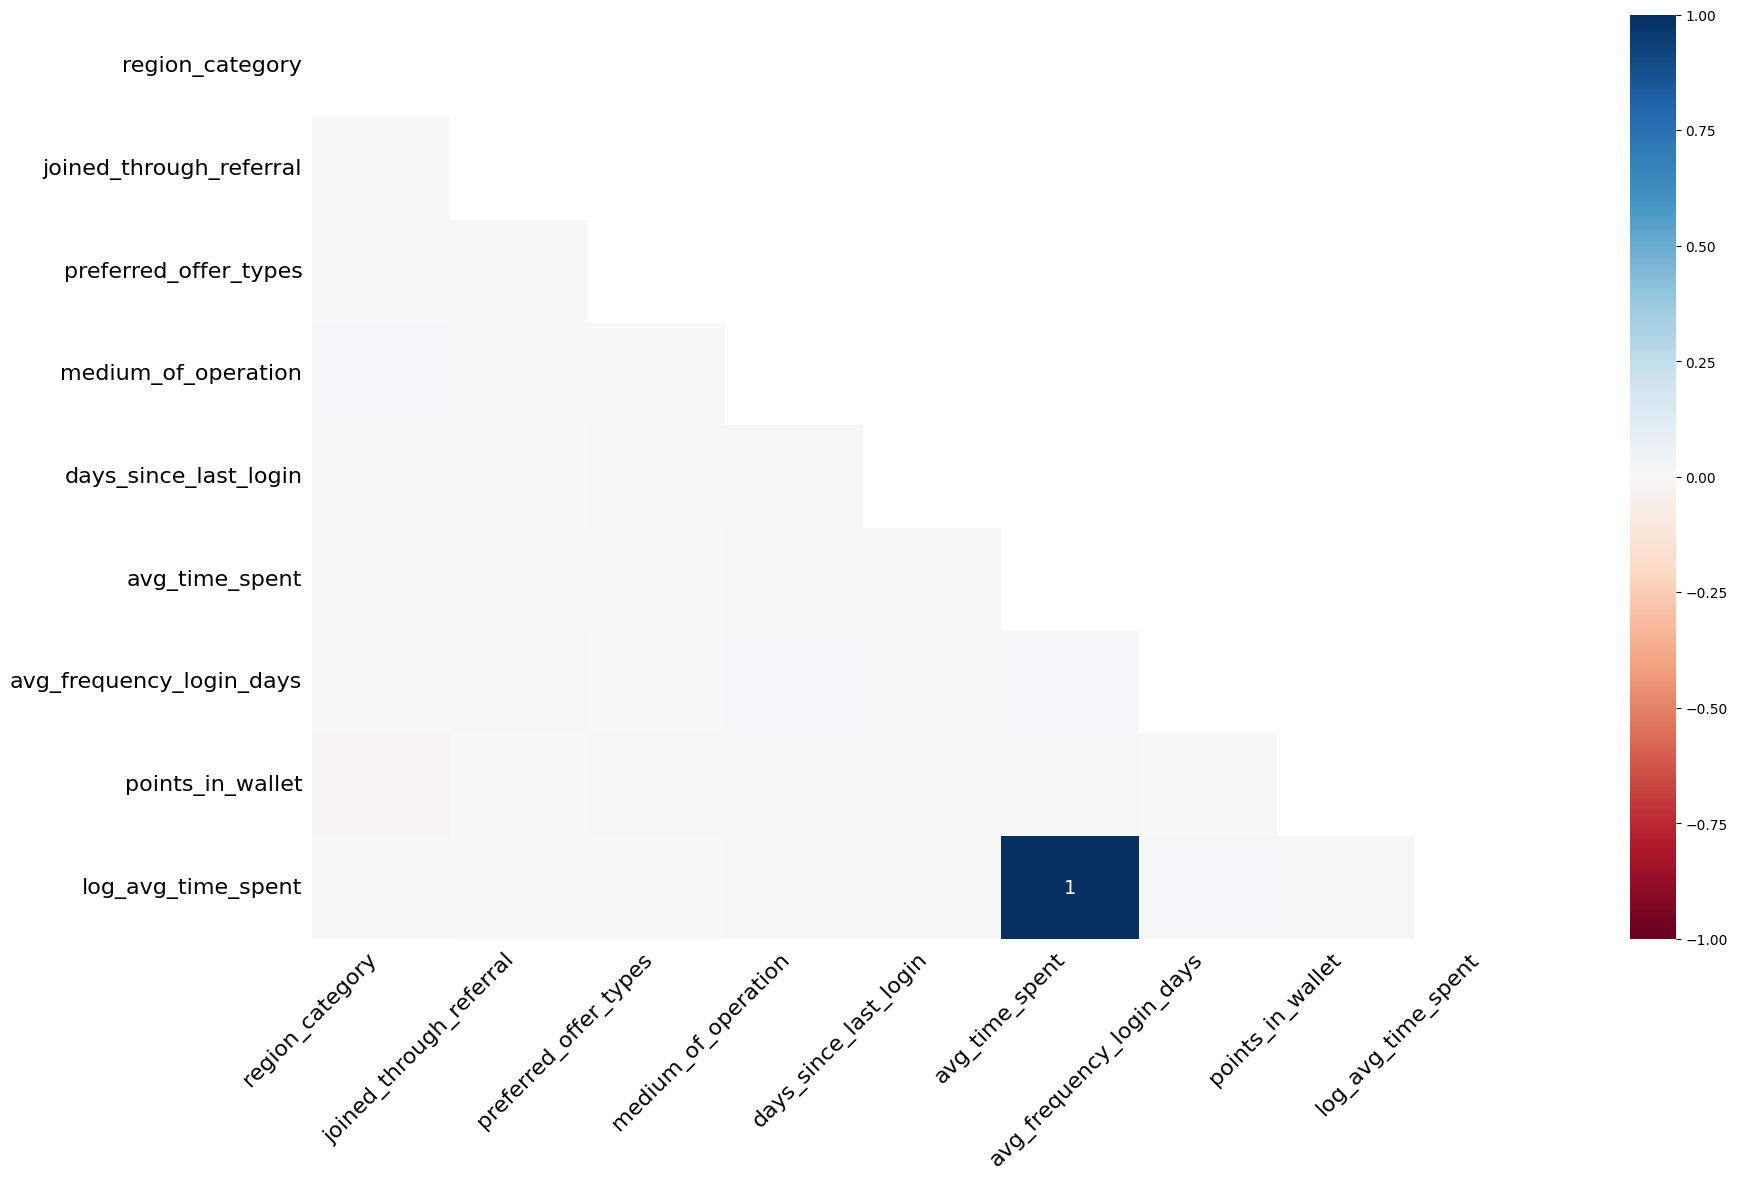

In [108]:
msno.heatmap(train_copy)
plt.show()

**Comments:**

It's clear that there is no patterns in missingness (if some columns are missing together)

### Sanity check

`referral_id` should be populated only when `joined_through_referral` is "Yes"

In [109]:
train_copy['referral_id'].isna().sum()

0

In [110]:
wrong_rows = ((train_copy['referral_id'] != 'xxxxxxxx') & (train_copy['joined_through_referral'] == 'No')) | \
				((train_copy['referral_id'] == 'xxxxxxxx') & (train_copy['joined_through_referral'] == 'Yes'))
train_copy.loc[wrong_rows]

,customer_id,Name,age,gender,security_no,region_category,membership_category,joining_date,joined_through_referral,referral_id,...,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,churn_risk_score,log_avg_time_spent
35697,fffe4300490044003700370031003800,Mechelle Roger,40,F,D7KJTIW,City,Premium Membership,2015-01-01,Yes,xxxxxxxx,...,38453.90,15.0,161.068864,Yes,No,No,Not Applicable,Poor Product Quality,3.0,5.148250
2024,fffe4300490044003700300032003300,Katrina Starnes,47,F,XBHIIP6,Town,No Membership,2015-01-01,Yes,xxxxxxxx,...,6577.58,12.0,573.230000,Yes,No,No,Not Applicable,Poor Product Quality,5.0,6.436375
11288,fffe43004900440032003000310031003800,Nicki Bains,50,F,MTVFBPP,Town,No Membership,2015-01-02,Yes,xxxxxxxx,...,10152.41,NaN,961.514863,Yes,No,Yes,No Information Available,Too many ads,4.0,6.531839
23077,fffe43004900440034003300310031003700,Rosetta Cratty,64,F,0JPMRNE,City,Premium Membership,2015-01-02,Yes,xxxxxxxx,...,7494.92,14.0,765.770000,No,Yes,Yes,Solved in Follow-up,No reason specified,3.0,NaN
2417,fffe430049004400340038003600,Aleta Streicher,37,M,4HVC1LS,City,Basic Membership,2015-01-03,Yes,xxxxxxxx,...,15121.62,29.0,667.090000,Yes,No,No,Not Applicable,Poor Product Quality,5.0,4.793805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2844,fffe43004900440033003500390032003800,Leslie Lampman,42,M,WVW0J5A,NaN,Platinum Membership,2017-12-27,Yes,xxxxxxxx,...,32285.32,12.0,782.620000,No,Yes,Yes,Solved,Poor Product Quality,3.0,3.512739
2313,fffe4300490044003200310033003600,Nolan Gosier,33,F,NC36U6W,City,Premium Membership,2017-12-28,Yes,xxxxxxxx,...,9330.00,28.0,1673.530938,No,Yes,Yes,Solved,Poor Website,3.0,3.533395
3007,fffe43004900440036003000370031003000,Nakita Jarnigan,28,F,RBMHMG3,Town,No Membership,2017-12-28,Yes,xxxxxxxx,...,39941.56,28.0,569.690000,Yes,No,Yes,No Information Available,No reason specified,5.0,3.518388
24163,fffe43004900440031003900320032003300,Rosio Liebel,15,F,FVA31BG,City,Gold Membership,2017-12-29,Yes,xxxxxxxx,...,48613.43,NaN,835.350000,Yes,No,Yes,Solved,Reasonable Price,1.0,6.744813


**Comments:**

There're lots of columns seems to have inconsistent data; how to deal with them?!

I prefer to not remove them because first we need to go back the data owners and ask them what it means when 'referral_id' is equal to 'xxxxxxxx'. 